# Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
from torchvision import transforms, models
from torchvision.utils import make_grid
from torch.utils.data import Dataset, random_split, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
from PIL import Image
from pathlib import Path

# Preparing the data

In [2]:
METADATA_COVID = Path('./covid-19-chest-xray/metadata.csv')
COVID_ROOT = Path('./covid-19-chest-xray/images')

PNEUMONIA_ROOT = Path('./chest_xray')
PNEUMONIA_TRAIN_ALL = PNEUMONIA_ROOT/'train'
PNEUMONIA_TRAIN = PNEUMONIA_ROOT/'train/PNEUMONIA'
NORMAL_TRAIN = PNEUMONIA_ROOT/'train/NORMAL'
PNEUMONIA_TEST = PNEUMONIA_ROOT/'test/PNEUMONIA'
NORMAL_TEST = PNEUMONIA_ROOT/'test/NORMAL'

#target label
TARGET_LABEL = {0: 'NORMAL',
               1: 'PNEUMONIA',
               2: 'COVID19'}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
pneumonia_data = []
for dirname, _, filenames in os.walk(PNEUMONIA_TRAIN_ALL):
    for filename in filenames:
        if filename.endswith(".jpeg"):
            pneumonia_data.append(os.path.join(dirname, filename))

image = []
label = []
for i in range(len(pneumonia_data)):
    image.append(pneumonia_data[i].split('/')[-1])
    label.append(pneumonia_data[i].split('/')[-2])

In [5]:
len(pneumonia_data)

5216

In [6]:
pneumonia_data[i]

'chest_xray/train/NORMAL/NORMAL2-IM-0478-0001.jpeg'

In [7]:
len(pneumonia_data)

5216

In [8]:
pneumonia_data[1000]

'chest_xray/train/PNEUMONIA/person308_bacteria_1445.jpeg'

In [9]:
image[2000]

'person1728_bacteria_4555.jpeg'

In [10]:
label[0:3]

['PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA']

In [11]:
label[-4:-1]

['NORMAL', 'NORMAL', 'NORMAL']

In [12]:
# pneumonia and normal data
df_pneumonia = pd.DataFrame({"label": label, "image_file": image})
df_pneumonia.head(10)

label                     image_file
0  PNEUMONIA       person292_virus_598.jpeg
1  PNEUMONIA   person643_bacteria_2534.jpeg
2  PNEUMONIA        person2_bacteria_3.jpeg
3  PNEUMONIA     person1062_virus_1762.jpeg
4  PNEUMONIA   person490_bacteria_2070.jpeg
5  PNEUMONIA  person1602_bacteria_4218.jpeg
6  PNEUMONIA       person145_virus_294.jpeg
7  PNEUMONIA     person1223_virus_2073.jpeg
8  PNEUMONIA     person1296_virus_2224.jpeg
9  PNEUMONIA  person1236_bacteria_3192.jpeg

In [13]:
df_pneumonia.describe()

label                image_file
count        5216                      5216
unique          2                      5216
top     PNEUMONIA  person292_virus_598.jpeg
freq         3875                         1

In [14]:
df_pneumonia['label'].value_counts()

PNEUMONIA    3875
NORMAL       1341
Name: label, dtype: int64

/home/tife/anaconda3/envs/covid-project/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


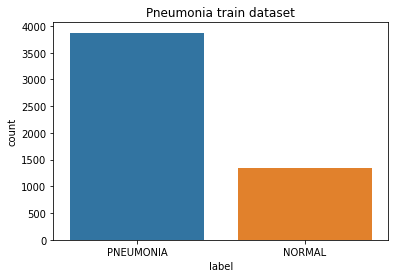

In [15]:
sns.countplot(df_pneumonia['label'])
plt.title('Pneumonia train dataset');

In [16]:
len(pneumonia_data)

5216

In [17]:
#covid19 data
df = pd.read_csv(METADATA_COVID)
df_pa = df.drop(df[df.view != 'PA'].index) #only take PA(from back to front film closer to chest) View
covid19 = df_pa[df_pa['finding']=='COVID-19'] #only take covid-19 label
covid19 = covid19[['finding', 'filename']] #take its label and image file
covid19.columns = (['label', 'image_file']) #change columns name same to pneumonia
#covid19[covid19['image_file'].str.endswith('.gz')]
covid19.reset_index(drop=True, inplace=True)

In [18]:
print('Data size:' , len(covid19))
covid19.head(10)

Data size: 141


label                                         image_file
0  COVID-19  auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
1  COVID-19  auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...
2  COVID-19  auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...
3  COVID-19  auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...
4  COVID-19                              nejmc2001573_f1a.jpeg
5  COVID-19                              nejmc2001573_f1b.jpeg
6  COVID-19                                  lancet-case2a.jpg
7  COVID-19                                  lancet-case2b.jpg
8  COVID-19               1-s2.0-S0140673620303706-fx1_lrg.jpg
9  COVID-19              nCoV-radiol.2020200269.fig1-day7.jpeg

In [19]:
#takes normal and pneumonia only 300 images
normal = df_pneumonia[df_pneumonia['label']=='NORMAL']
normal = normal.sample(frac=1, axis=0, random_state=7).reset_index(drop=True) #shuffle rows
normal = normal[:141] #same with covid19 data

pneumonia = df_pneumonia[df_pneumonia['label']=='PNEUMONIA']
pneumonia = pneumonia.sample(frac=1, axis=0, random_state=7).reset_index(drop=True)
pnuemonia = pneumonia[:141] #same with covid19 data

#concat all data (covid, pneumonia and normal)
all_data = pd.concat([normal, pnuemonia, covid19], ignore_index=True)
all_data = all_data.sample(frac=1, axis=0, random_state=7).reset_index(drop=True)
all_data.head(10)

label                                         image_file
0   COVID-19          01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg
1  PNEUMONIA                         person1455_virus_2489.jpeg
2  PNEUMONIA                       person266_bacteria_1248.jpeg
3   COVID-19          E63574A7-4188-4C8D-8D17-9D67A18A1AFA.jpeg
4  PNEUMONIA                      person1582_bacteria_4137.jpeg
5     NORMAL                          NORMAL2-IM-1273-0001.jpeg
6   COVID-19                                      16654_1_1.png
7     NORMAL                                  IM-0613-0001.jpeg
8  PNEUMONIA                      person1670_bacteria_4431.jpeg
9   COVID-19  1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...

In [20]:
all_data.nunique()

label           3
image_file    423
dtype: int64

/home/tife/anaconda3/envs/covid-project/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


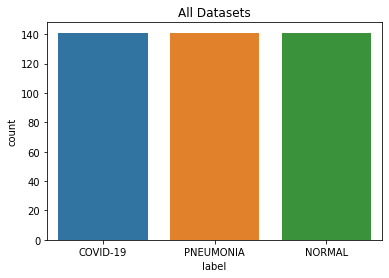

In [21]:
sns.countplot(all_data['label'])
plt.title('All Datasets');

In [22]:
#split dataset
X_trainval, X_test, y_trainval, y_test = train_test_split(all_data['image_file'].values,
                                                      all_data['label'].values, test_size=0.05,
                                                      stratify=all_data['label'].values, random_state=7)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.1,
                                                  random_state=7)

len(X_train), len(X_val), len(X_test)

(360, 41, 22)

In [23]:
class Xray_split(Dataset):
    def __init__(self, root_dir_pnue, root_dir_covid, X, y, transform=None):
        self.pnue_root = root_dir_pnue
        self.covid_root = root_dir_covid
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image, label = self.X[idx], self.y[idx]
        if self.y[idx] == 'COVID-19':
            label = 2
            img_fname = str(self.covid_root) + "/" + str(image)
            img = Image.open(img_fname).convert("L")           
            if self.transform:
                img = self.transform(img)
        
        if self.y[idx] == 'NORMAL':
            label = 0
            img_fname = str(self.pnue_root) + "/NORMAL/" + str(image)
            img = Image.open(img_fname)
          
 
            if self.transform:
                img = self.transform(img)
        
        if self.y[idx] == 'PNEUMONIA':
            label = 1
            img_fname = str(self.pnue_root) + "/PNEUMONIA/" + str(image)
            img = Image.open(img_fname)
            
            if self.transform:
                img = self.transform(img)
                
        return img, int(label)

In [24]:
# mean = [0.4947]
# std = [0.2226]
mean = [0.0960, 0.0960, 0.0960]
std = [0.9341, 0.9341, 0.9341]

train_transform = transforms.Compose([transforms.Resize((512, 512)),
                                      transforms.Grayscale(3),
                                      transforms.RandomResizedCrop((224, 224)),
                                      transforms.RandomRotation(15),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
                                     ])

val_transform = transforms.Compose([transforms.Resize((512, 512)),
                                    transforms.Grayscale(3),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std),
                                   ])

test_transform = transforms.Compose([transforms.Resize((512, 512)),
                                     transforms.Grayscale(3),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std),
                                   ])


train_set = Xray_split(PNEUMONIA_TRAIN_ALL, COVID_ROOT, X_train, y_train, train_transform)
val_set = Xray_split(PNEUMONIA_TRAIN_ALL, COVID_ROOT, X_val, y_val, val_transform)
test_set = Xray_split(PNEUMONIA_TRAIN_ALL, COVID_ROOT, X_test, y_test, test_transform)

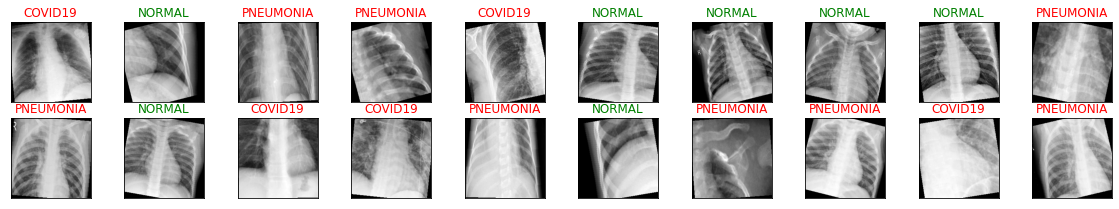

In [25]:
#look the training data (already transformed)
fig = plt.figure(figsize=(20, 5))

for i in range(20):
    image, label = train_set[i]
    ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks = [])
    ax.imshow(image[0], cmap='gray')
    ax.set_title(TARGET_LABEL[label], color=("green" if label == 0 else 'red'))

In [26]:
batch_size = 2

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size*2, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [27]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 25))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


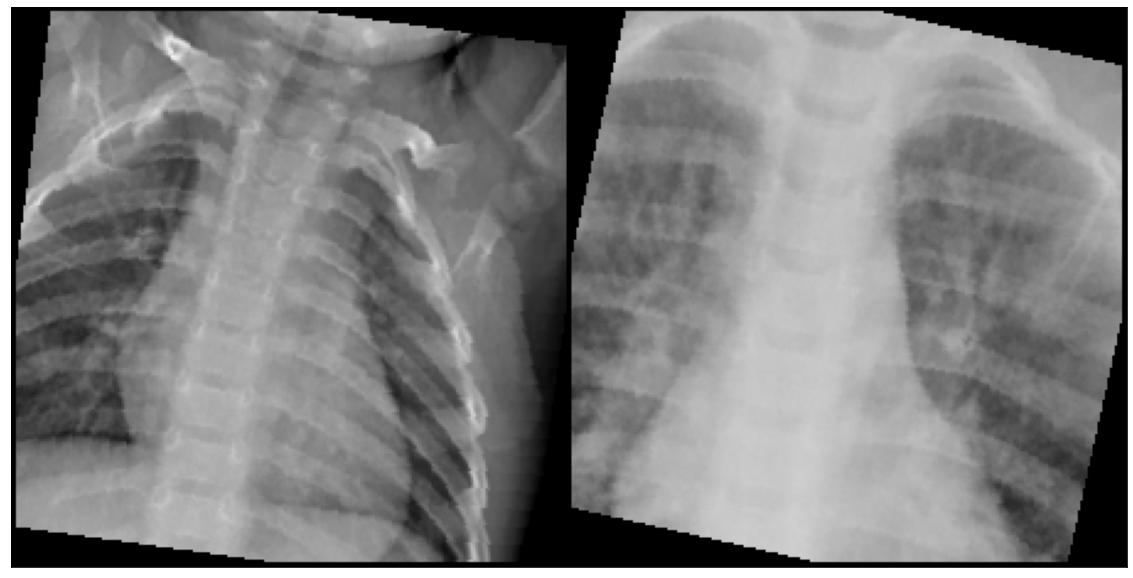

In [28]:
show_batch(train_loader)

# Model architecture

In [29]:
#for get learning rate parameter
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#training loop
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    torch.cuda.empty_cache()
    
    #save variabel
    train_losses = []
    test_losses = []
    train_scores = []
    val_score = []
    lrs = []

    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        train_score = 0
        
        #training loop#
        for image, label in train_loader:
            #training phase
            model.train()
            
            image = image.to(device); label = label.to(device);
            
            output = model(image)
            #accuracy calulcation
            ps = torch.exp(output)
            _, top_class = ps.topk(1, dim=1)
            correct = top_class == label.view(*top_class.shape)
            train_score += torch.mean(correct.type(torch.FloatTensor))
            #loss
            loss = criterion(output, label)
            #backward pass
            loss.backward()
            #update weight
            optimizer.step()
            optimizer.zero_grad()
            
            scheduler.step() 
            lrs.append(get_lr(optimizer))
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            scores = 0
            #validation loop#
            with torch.no_grad():
                for image, label in val_loader:
                    image = image.to(device); label = label.to(device);

                    output = model(image)

                    #accuracy calulcation
                    ps = torch.exp(output)
                    _, top_class = ps.topk(1, dim=1)
                    correct = top_class == label.view(*top_class.shape)
                    scores += torch.mean(correct.type(torch.FloatTensor))
                    #loss
                    loss = criterion(output, label)                                  
                    test_loss += loss.item()
            
            #calculation mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))
            train_scores.append(train_score/len(train_loader))
            val_score.append(scores/len(val_loader))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Train Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}.. ".format(test_loss/len(val_loader)),
                  "Train acc Score: {:.3f}.. ".format(train_score/len(train_loader)),
                  "Val acc : {:.3f}.. ".format(scores/len(val_loader)),
                  "Lr: {:.4f} ".format(get_lr(optimizer)),
                  "Time: {:.2f}s" .format(time.time()-since)
                 )
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses, 
               'train_acc': train_scores, 'val_acc':val_score, 'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

def plot_loss(history, n_epoch):
    epoch = [x for x in range(1, n_epoch+1)]
    plt.plot(epoch, history['train_loss'], label='Train_loss')
    plt.plot(epoch, history['val_loss'], label='val_loss')
    plt.title('Loss per epoch')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(); 
    plt.show()

def plot_score(history, n_epoch):
    epoch = [x for x in range(1, n_epoch+1)]
    plt.plot(epoch, history['train_acc'], label='Train_acc')
    plt.plot(epoch, history['val_acc'], label='val_acc')
    plt.title('Accuracy per epoch')
    plt.ylabel('score')
    plt.xlabel('epoch')
    plt.legend(); 
    plt.show()

def plot_lr(history):
    plt.plot(history['lrs'], label='learning rate')
    plt.title('One Cycle Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('steps')
    plt.legend(); 
    plt.show()

# MobileNetv2

In [30]:
output_label = 3

model_mobile = models.mobilenet_v2(pretrained=True)

model_mobile.classifier = nn.Sequential(nn.Linear(in_features=1280, out_features=output_label))

model_mobile.to(device);
model_mobile

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [31]:
max_lr = 0.0001
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mobile.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch, 
                                            steps_per_epoch=len(train_loader))
mobile_history = fit(epoch, model_mobile, train_loader, val_loader, criterion, optimizer, sched)

Epoch: 1/20..  Train Loss: 1.065..  Val Loss: 1.010..  Train acc Score: 0.439..  Val acc : 0.523..  Lr: 0.0000  Time: 74.43s
Epoch: 2/20..  Train Loss: 0.894..  Val Loss: 0.614..  Train acc Score: 0.600..  Val acc : 0.909..  Lr: 0.0000  Time: 47.13s
Epoch: 3/20..  Train Loss: 0.718..  Val Loss: 0.489..  Train acc Score: 0.708..  Val acc : 0.864..  Lr: 0.0001  Time: 85.55s
Epoch: 4/20..  Train Loss: 0.812..  Val Loss: 0.541..  Train acc Score: 0.669..  Val acc : 0.795..  Lr: 0.0001  Time: 48.82s
Epoch: 5/20..  Train Loss: 0.750..  Val Loss: 0.769..  Train acc Score: 0.694..  Val acc : 0.591..  Lr: 0.0001  Time: 49.48s
Epoch: 6/20..  Train Loss: 0.694..  Val Loss: 0.424..  Train acc Score: 0.708..  Val acc : 0.864..  Lr: 0.0001  Time: 49.58s
Epoch: 7/20..  Train Loss: 0.706..  Val Loss: 0.469..  Train acc Score: 0.703..  Val acc : 0.818..  Lr: 0.0001  Time: 48.65s
Epoch: 8/20..  Train Loss: 0.699..  Val Loss: 0.263..  Train acc Score: 0.739..  Val acc : 0.955..  Lr: 0.0001  Time: 49.40s


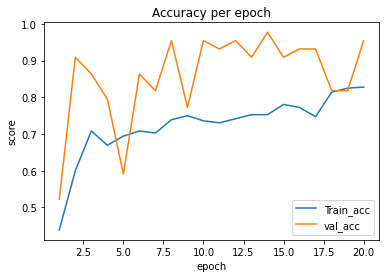

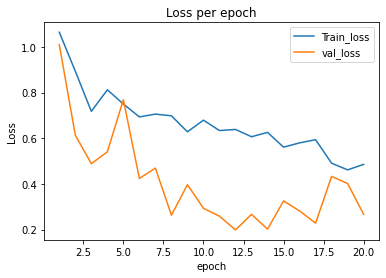

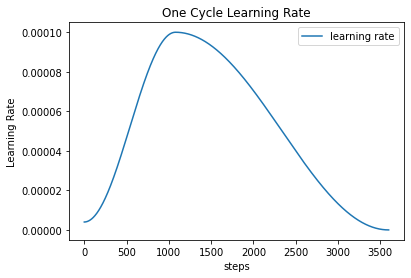

In [32]:
torch.save(model_mobile.state_dict(),'mobilenet.pth')
plot_score(mobile_history, epoch)
plot_loss(mobile_history, epoch)
plot_lr(mobile_history)

In [33]:
def predict_dataset(dataset, model):
    model.eval()
    model.to(device)
    torch.cuda.empty_cache()
    predict = []
    y_true = []
    for image, label in dataset:
        #image = image.to(device); label= label.to(device)
        image = image.unsqueeze(0)
        image = image.to(device);
        
        output = model(image)
        ps = torch.exp(output)
        _, top_class = ps.topk(1, dim=1)
        
        predic = np.squeeze(top_class.cpu().numpy())
        predict.append(predic)
        y_true.append(label)
    return list(y_true), list(np.array(predict).reshape(1,-1).squeeze(0))

def report(y_true, y_predict, title='MODEL OVER TEST SET'):
    print(classification_report(y_true, y_predict))
    sns.heatmap(confusion_matrix(y_true, y_predict), annot=True)
    plt.yticks(np.arange(0.5, len(TARGET_LABEL)), labels=list(TARGET_LABEL.values()), rotation=0);
    plt.xticks(np.arange(0.5, len(TARGET_LABEL)), labels=list(TARGET_LABEL.values()), rotation=45)
    plt.title(title)
    plt.show()
    
def plot_predict(test_set, y_predict):
    """it takes longer time to plot, if you want it faster
    comment or delete tight_layout
    """
    fig = plt.figure(figsize=(20, 20))

    for i in range(len(test_set)):
        image, label = test_set[i]
        ax = fig.add_subplot(4, 6, i+1, xticks=[], yticks = [])
        ax.imshow(image[0], cmap='gray')
        ax.set_title("{}({})" .format(TARGET_LABEL[y_predict[i]], TARGET_LABEL[label]), 
                      color=("green" if y_predict[i] == label else 'red'), fontsize=12)

    plt.tight_layout() #want faster comment or delete this
    plt.show()

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.70      1.00      0.82         7
           2       1.00      0.88      0.93         8

    accuracy                           0.86        22
   macro avg       0.90      0.86      0.86        22
weighted avg       0.90      0.86      0.87        22



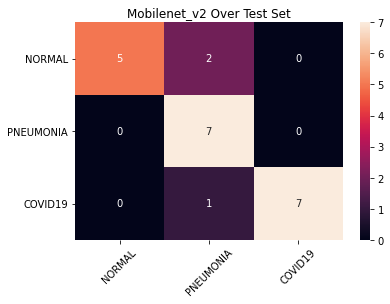

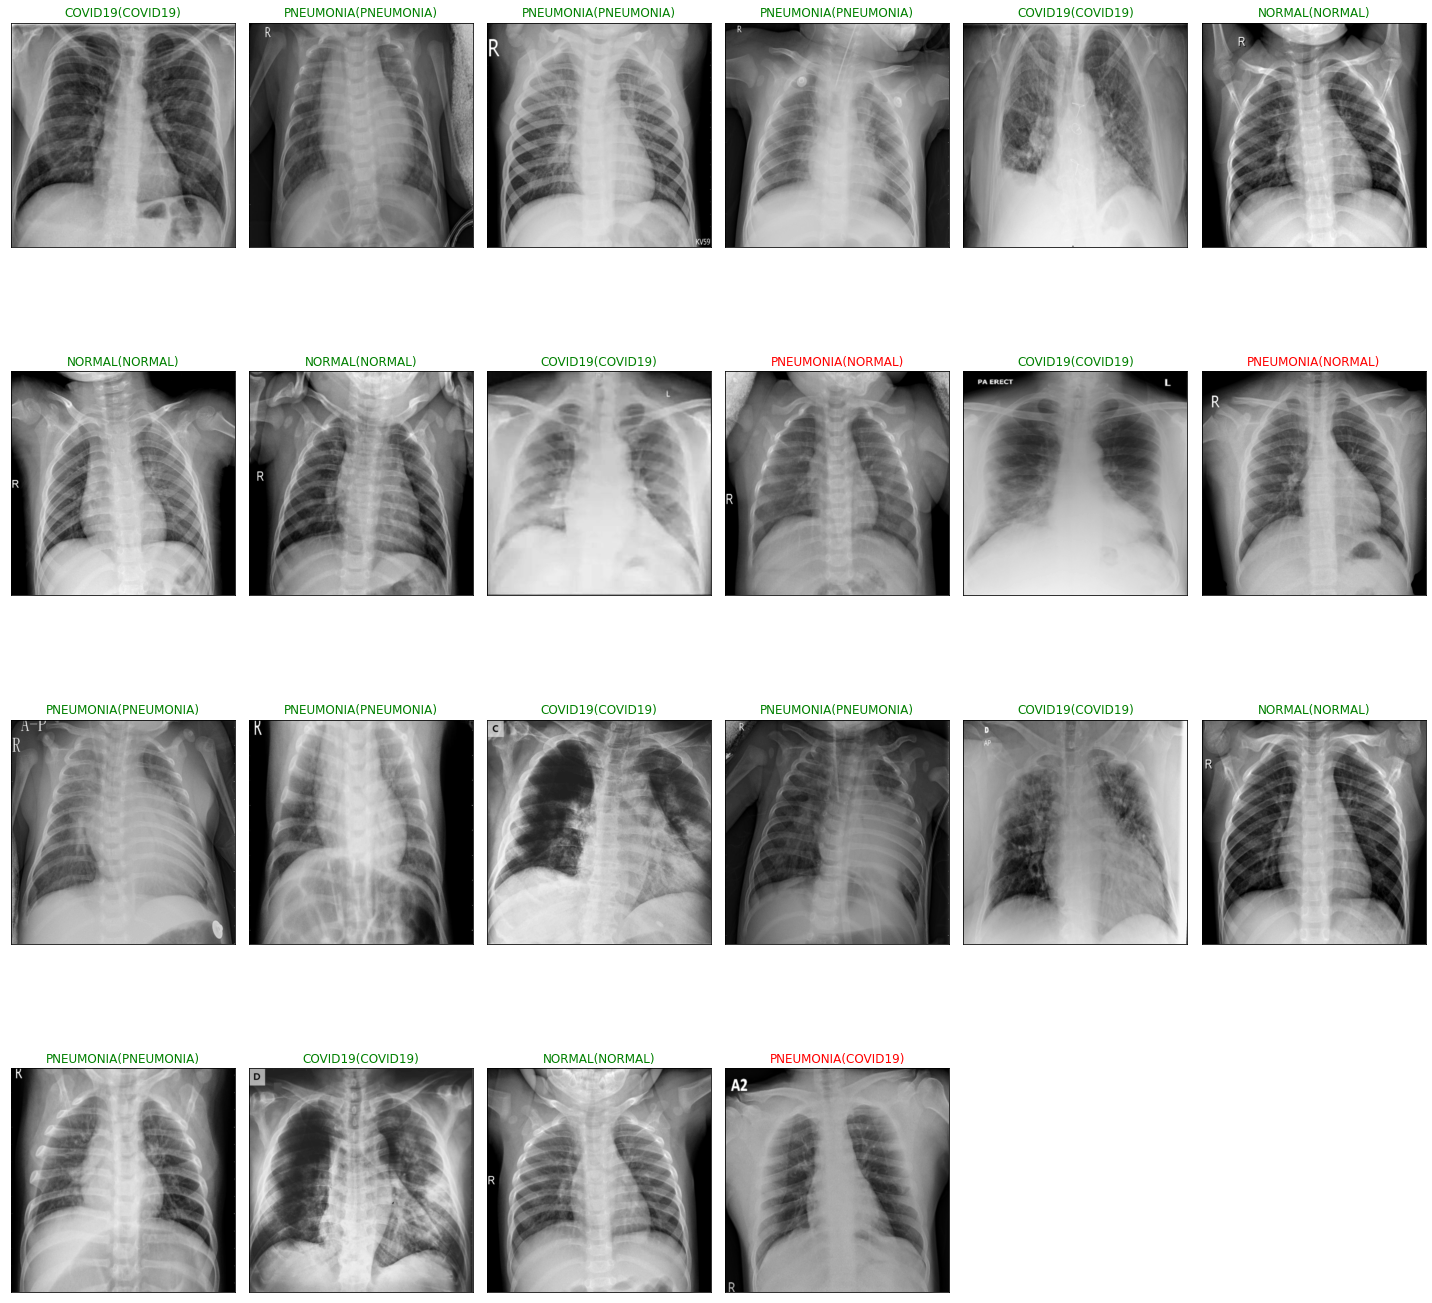

In [34]:
y_true, y_predict = predict_dataset(test_set, model_mobile)
report(y_true, y_predict, title='Mobilenet_v2 Over Test Set')
plot_predict(test_set, y_predict)

# VGG16 Pretrained model

In [35]:
vgg16_model = models.vgg16(pretrained=True)
vgg16_model.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features=30, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=30, out_features=3, bias=True)
                                       )
vgg16_model.to(device)
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
max_lr = 0.0001
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch, 
                                            steps_per_epoch=len(train_loader))

history_vgg16 = fit(epoch, vgg16_model, train_loader, val_loader, criterion, optimizer, sched)

Epoch: 1/20..  Train Loss: 1.047..  Val Loss: 0.994..  Train acc Score: 0.431..  Val acc : 0.750..  Lr: 0.0000  Time: 187.76s
Epoch: 2/20..  Train Loss: 0.807..  Val Loss: 0.742..  Train acc Score: 0.625..  Val acc : 0.795..  Lr: 0.0000  Time: 196.38s
Epoch: 3/20..  Train Loss: 0.762..  Val Loss: 0.852..  Train acc Score: 0.697..  Val acc : 0.455..  Lr: 0.0001  Time: 200.17s
Epoch: 4/20..  Train Loss: 0.658..  Val Loss: 0.954..  Train acc Score: 0.725..  Val acc : 0.432..  Lr: 0.0001  Time: 200.53s
Epoch: 5/20..  Train Loss: 0.935..  Val Loss: 0.865..  Train acc Score: 0.600..  Val acc : 0.591..  Lr: 0.0001  Time: 200.56s
Epoch: 6/20..  Train Loss: 0.968..  Val Loss: 0.690..  Train acc Score: 0.544..  Val acc : 0.886..  Lr: 0.0001  Time: 199.12s
Epoch: 7/20..  Train Loss: 0.754..  Val Loss: 0.590..  Train acc Score: 0.661..  Val acc : 0.932..  Lr: 0.0001  Time: 200.60s
Epoch: 8/20..  Train Loss: 0.668..  Val Loss: 0.357..  Train acc Score: 0.753..  Val acc : 0.955..  Lr: 0.0001  Time: 

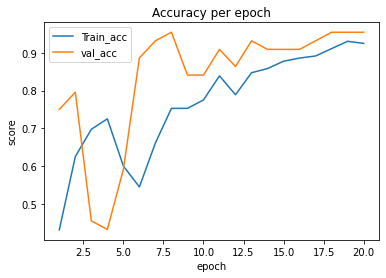

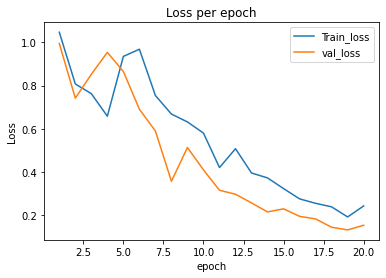

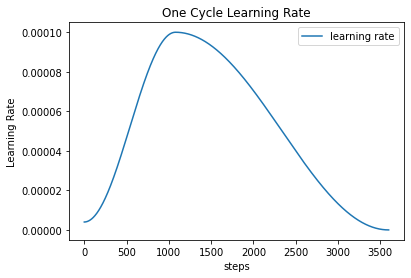

In [37]:
torch.save(vgg16_model.state_dict(),'vgg16.pth')
plot_score(history_vgg16, epoch)
plot_loss(history_vgg16, epoch)
plot_lr(history_vgg16)

In [43]:
def predict_dataset(dataset, model):
    model.eval()
    model.to(device)
    torch.cuda.empty_cache()
    predict = []
    y_true = []
    for image, label in dataset:
        #image = image.to(device); label= label.to(device)
        image = image.unsqueeze(0)
        image = image.to(device);
        
        output = model(image)
        ps = torch.exp(output)
        _, top_class = ps.topk(1, dim=1)
        
        predic = np.squeeze(top_class.cpu().numpy())
        predict.append(predic)
        y_true.append(label)
    return list(y_true), list(np.array(predict).reshape(1,-1).squeeze(0))

def report(y_true, y_predict, title='MODEL OVER TEST SET'):
    print(classification_report(y_true, y_predict))
    sns.heatmap(confusion_matrix(y_true, y_predict), annot=True)
    plt.yticks(np.arange(0.5, len(TARGET_LABEL)), labels=list(TARGET_LABEL.values()), rotation=0);
    plt.xticks(np.arange(0.5, len(TARGET_LABEL)), labels=list(TARGET_LABEL.values()), rotation=45)
    plt.title(title)
    plt.show()
    
def plot_predict(test_set, y_predict):
    """it takes longer time to plot, if you want it faster
    comment or delete tight_layout
    """
    fig = plt.figure(figsize=(20, 20))

    for i in range(len(test_set)):
        image, label = test_set[i]
        ax = fig.add_subplot(4, 6, i+1, xticks=[], yticks = [])
        ax.imshow(image[0], cmap='gray')
        ax.set_title("{}({})" .format(TARGET_LABEL[y_predict[i]], TARGET_LABEL[label]), 
                      color=("green" if y_predict[i] == label else 'red'), fontsize=12)

    plt.tight_layout() #want faster comment or delete this
    plt.show()

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.78      1.00      0.88         7
           2       1.00      1.00      1.00         8

    accuracy                           0.91        22
   macro avg       0.93      0.90      0.90        22
weighted avg       0.93      0.91      0.91        22



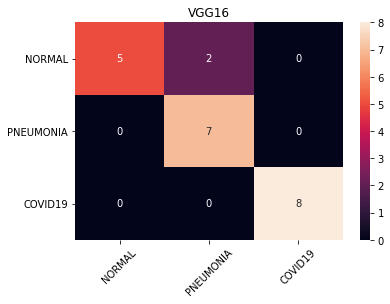

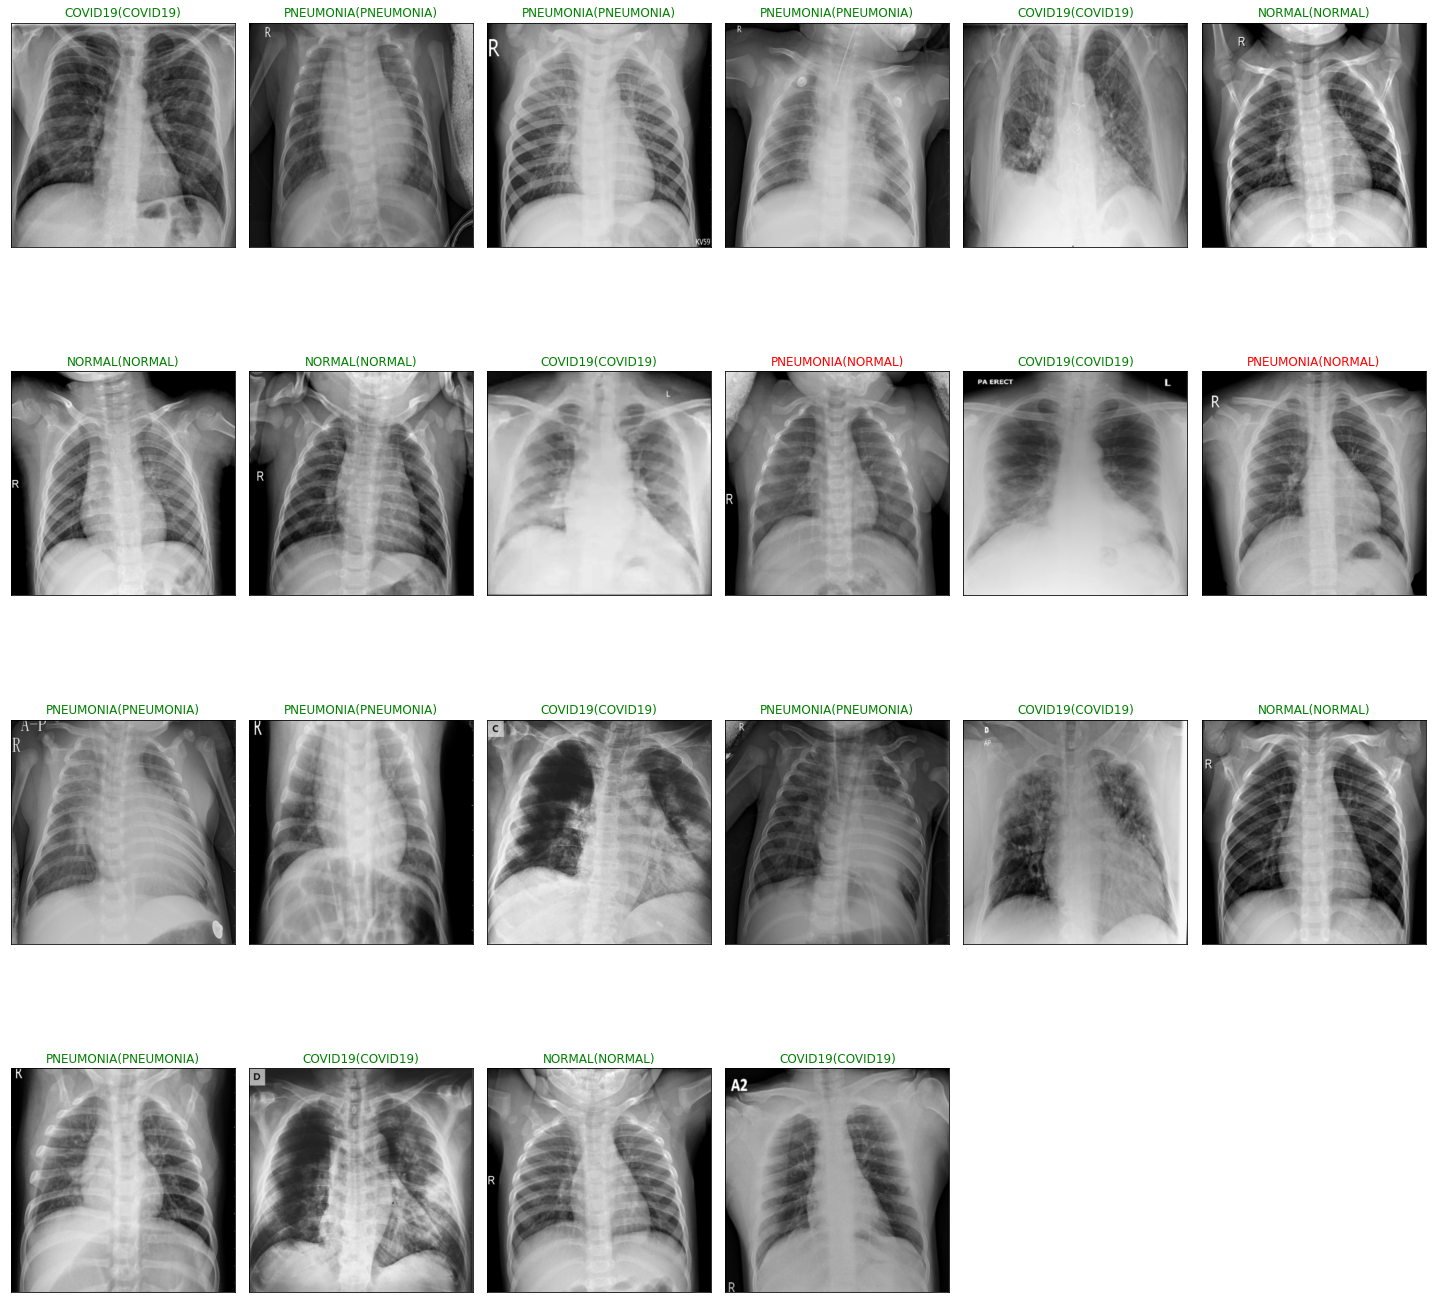

In [44]:
y_true, y_predict = predict_dataset(test_set, vgg16_model)
report(y_true, y_predict, 'VGG16')
plot_predict(test_set, y_predict)

# Resnet18 pretrained model

In [45]:
output_label = 3
resnet18_model = models.resnet18(pretrained=True)
resnet18_model.fc = nn.Linear(512, output_label)

resnet18_model.to(device)
resnet18_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
max_lr = 0.0001
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch, 
                                            steps_per_epoch=len(train_loader))

history_resnet18 = fit(epoch, resnet18_model, train_loader, val_loader, criterion, optimizer, sched)

Epoch: 1/20..  Train Loss: 1.245..  Val Loss: 1.064..  Train acc Score: 0.342..  Val acc : 0.318..  Lr: 0.0000  Time: 57.09s
Epoch: 2/20..  Train Loss: 0.909..  Val Loss: 0.687..  Train acc Score: 0.564..  Val acc : 0.773..  Lr: 0.0000  Time: 56.81s
Epoch: 3/20..  Train Loss: 0.761..  Val Loss: 0.700..  Train acc Score: 0.678..  Val acc : 0.636..  Lr: 0.0001  Time: 67.76s
Epoch: 4/20..  Train Loss: 0.839..  Val Loss: 0.584..  Train acc Score: 0.617..  Val acc : 0.795..  Lr: 0.0001  Time: 66.97s
Epoch: 5/20..  Train Loss: 0.859..  Val Loss: 0.598..  Train acc Score: 0.611..  Val acc : 0.795..  Lr: 0.0001  Time: 68.05s
Epoch: 6/20..  Train Loss: 0.743..  Val Loss: 0.464..  Train acc Score: 0.697..  Val acc : 0.886..  Lr: 0.0001  Time: 57.19s
Epoch: 7/20..  Train Loss: 0.718..  Val Loss: 0.495..  Train acc Score: 0.694..  Val acc : 0.841..  Lr: 0.0001  Time: 57.25s
Epoch: 8/20..  Train Loss: 0.617..  Val Loss: 0.583..  Train acc Score: 0.767..  Val acc : 0.636..  Lr: 0.0001  Time: 57.60s


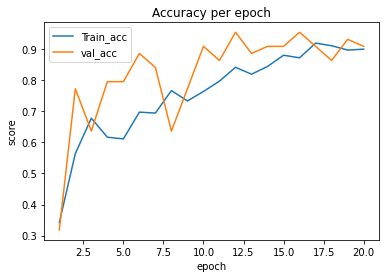

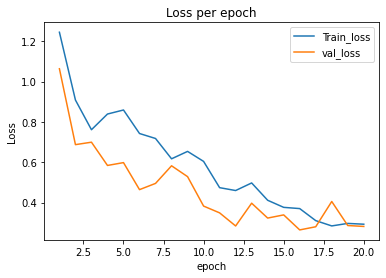

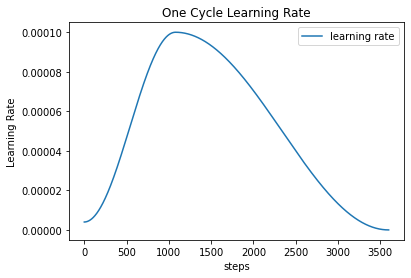

In [47]:
torch.save(resnet18_model.state_dict(),'resnet18.pth')
plot_score(history_resnet18, epoch)
plot_loss(history_resnet18, epoch)
plot_lr(history_resnet18)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.88      1.00      0.93         7
           2       1.00      0.88      0.93         8

    accuracy                           0.95        22
   macro avg       0.96      0.96      0.96        22
weighted avg       0.96      0.95      0.95        22



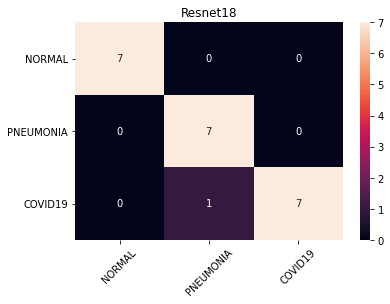

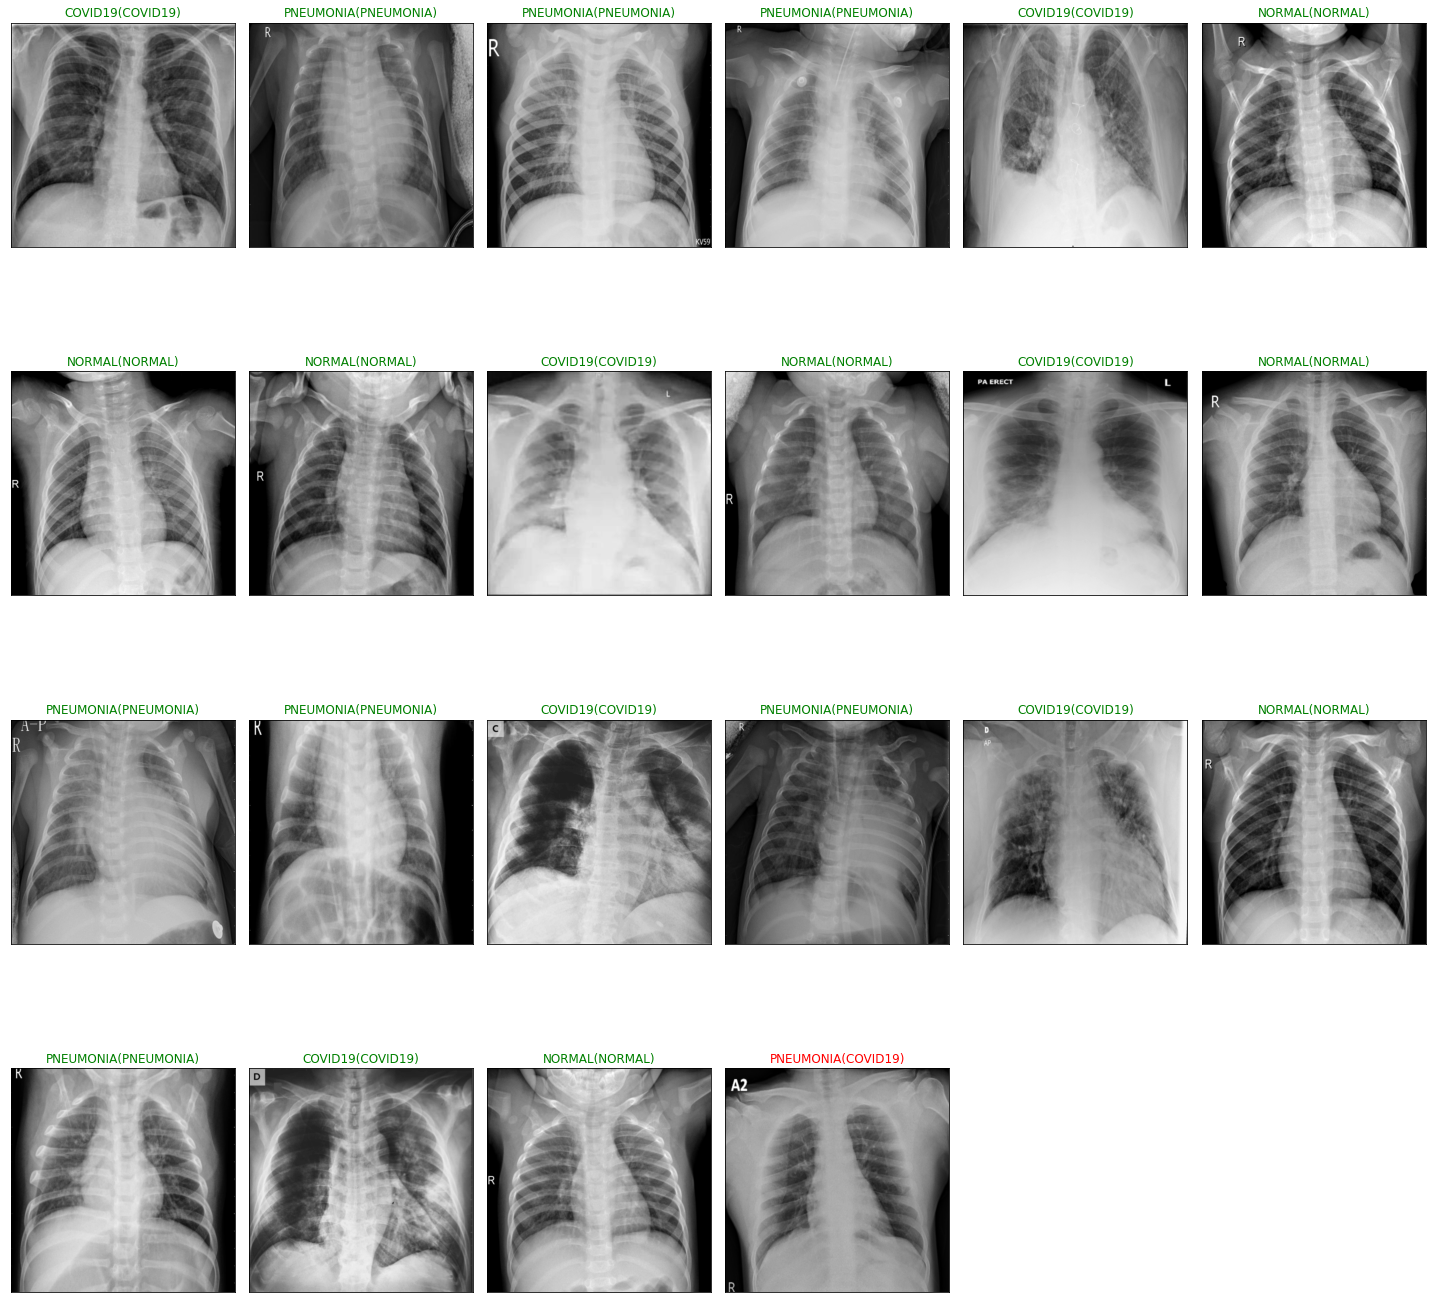

In [48]:
y_true, y_predict = predict_dataset(test_set, resnet18_model)
report(y_true, y_predict, 'Resnet18')
plot_predict(test_set, y_predict)

# Evaluation (chapter four)

In [33]:
def predict_dataset(dataset, model):
    model.eval()
    model.to(device)
    torch.cuda.empty_cache()
    predict = []
    y_true = []
    for image, label in dataset:
        #image = image.to(device); label= label.to(device)
        image = image.unsqueeze(0)
        image = image.to(device);
        
        output = model(image)
        ps = torch.exp(output)
        _, top_class = ps.topk(1, dim=1)
        
        predic = np.squeeze(top_class.cpu().numpy())
        predict.append(predic)
        y_true.append(label)
    return list(y_true), list(np.array(predict).reshape(1,-1).squeeze(0))

def report(y_true, y_predict, title='MODEL OVER TEST SET'):
    print(classification_report(y_true, y_predict))
    sns.heatmap(confusion_matrix(y_true, y_predict), annot=True)
    plt.yticks(np.arange(0.5, len(TARGET_LABEL)), labels=list(TARGET_LABEL.values()), rotation=0);
    plt.xticks(np.arange(0.5, len(TARGET_LABEL)), labels=list(TARGET_LABEL.values()), rotation=45)
    plt.title(title)
    plt.show()
    
def plot_predict(test_set, y_predict):
    """it takes longer time to plot, if you want it faster
    comment or delete tight_layout
    """
    fig = plt.figure(figsize=(20, 20))

    for i in range(len(test_set)):
        image, label = test_set[i]
        ax = fig.add_subplot(4, 6, i+1, xticks=[], yticks = [])
        ax.imshow(image[0], cmap='gray')
        ax.set_title("{}({})" .format(TARGET_LABEL[y_predict[i]], TARGET_LABEL[label]), 
                      color=("green" if y_predict[i] == label else 'red'), fontsize=12)

    plt.tight_layout() #want faster comment or delete this
    plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.35      1.00      0.52         7
           2       1.00      0.12      0.22         8

    accuracy                           0.36        22
   macro avg       0.45      0.38      0.25        22
weighted avg       0.47      0.36      0.25        22



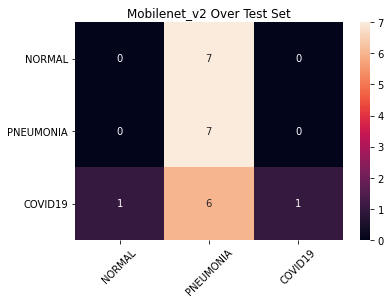

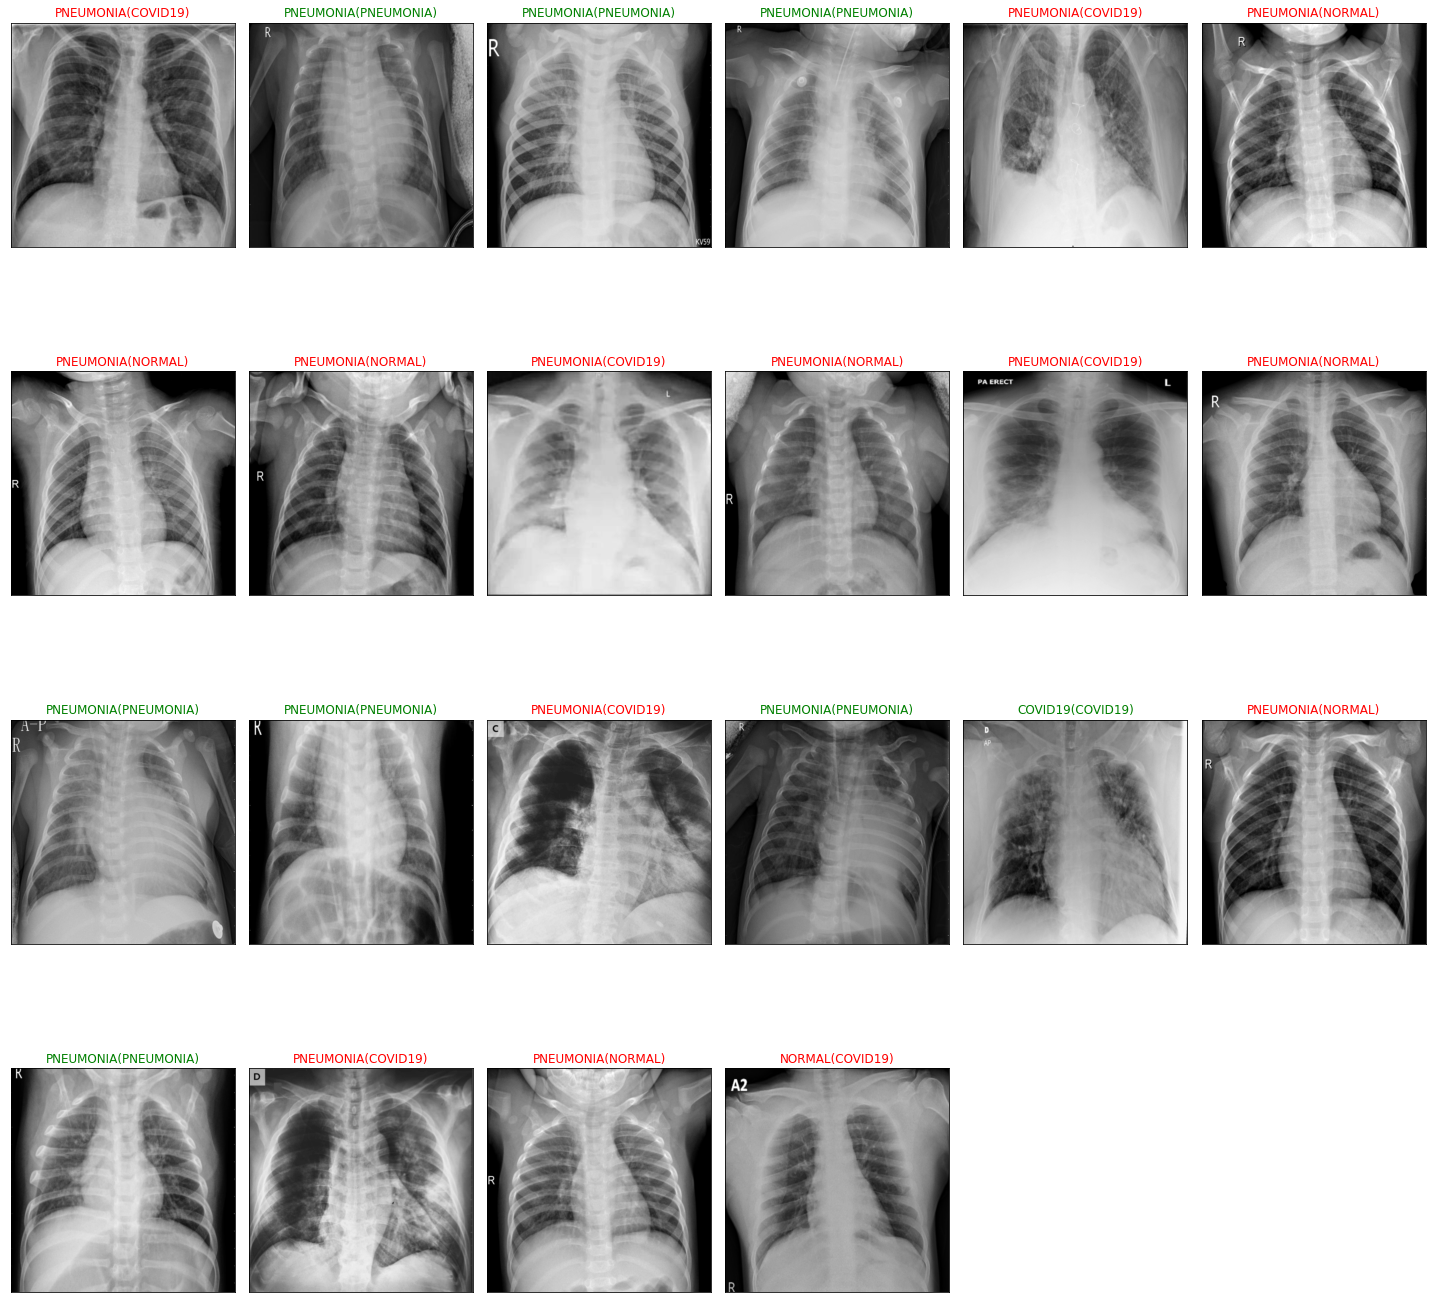

In [34]:
y_true, y_predict = predict_dataset(test_set, model_mobile)
report(y_true, y_predict, title='Mobilenet_v2 Over Test Set')
plot_predict(test_set, y_predict)

/home/tife/anaconda3/envs/covid-project/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tife/anaconda3/envs/covid-project/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tife/anaconda3/envs/covid-project/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

              precision    recall  f1-score   support

           0       0.29      0.86      0.43         7
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         8

    accuracy                           0.27        22
   macro avg       0.10      0.29      0.14        22
weighted avg       0.09      0.27      0.14        22



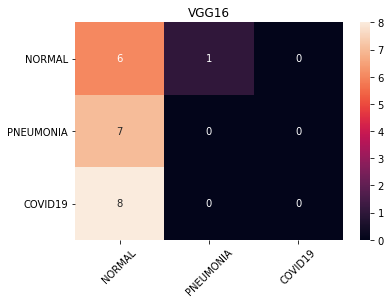

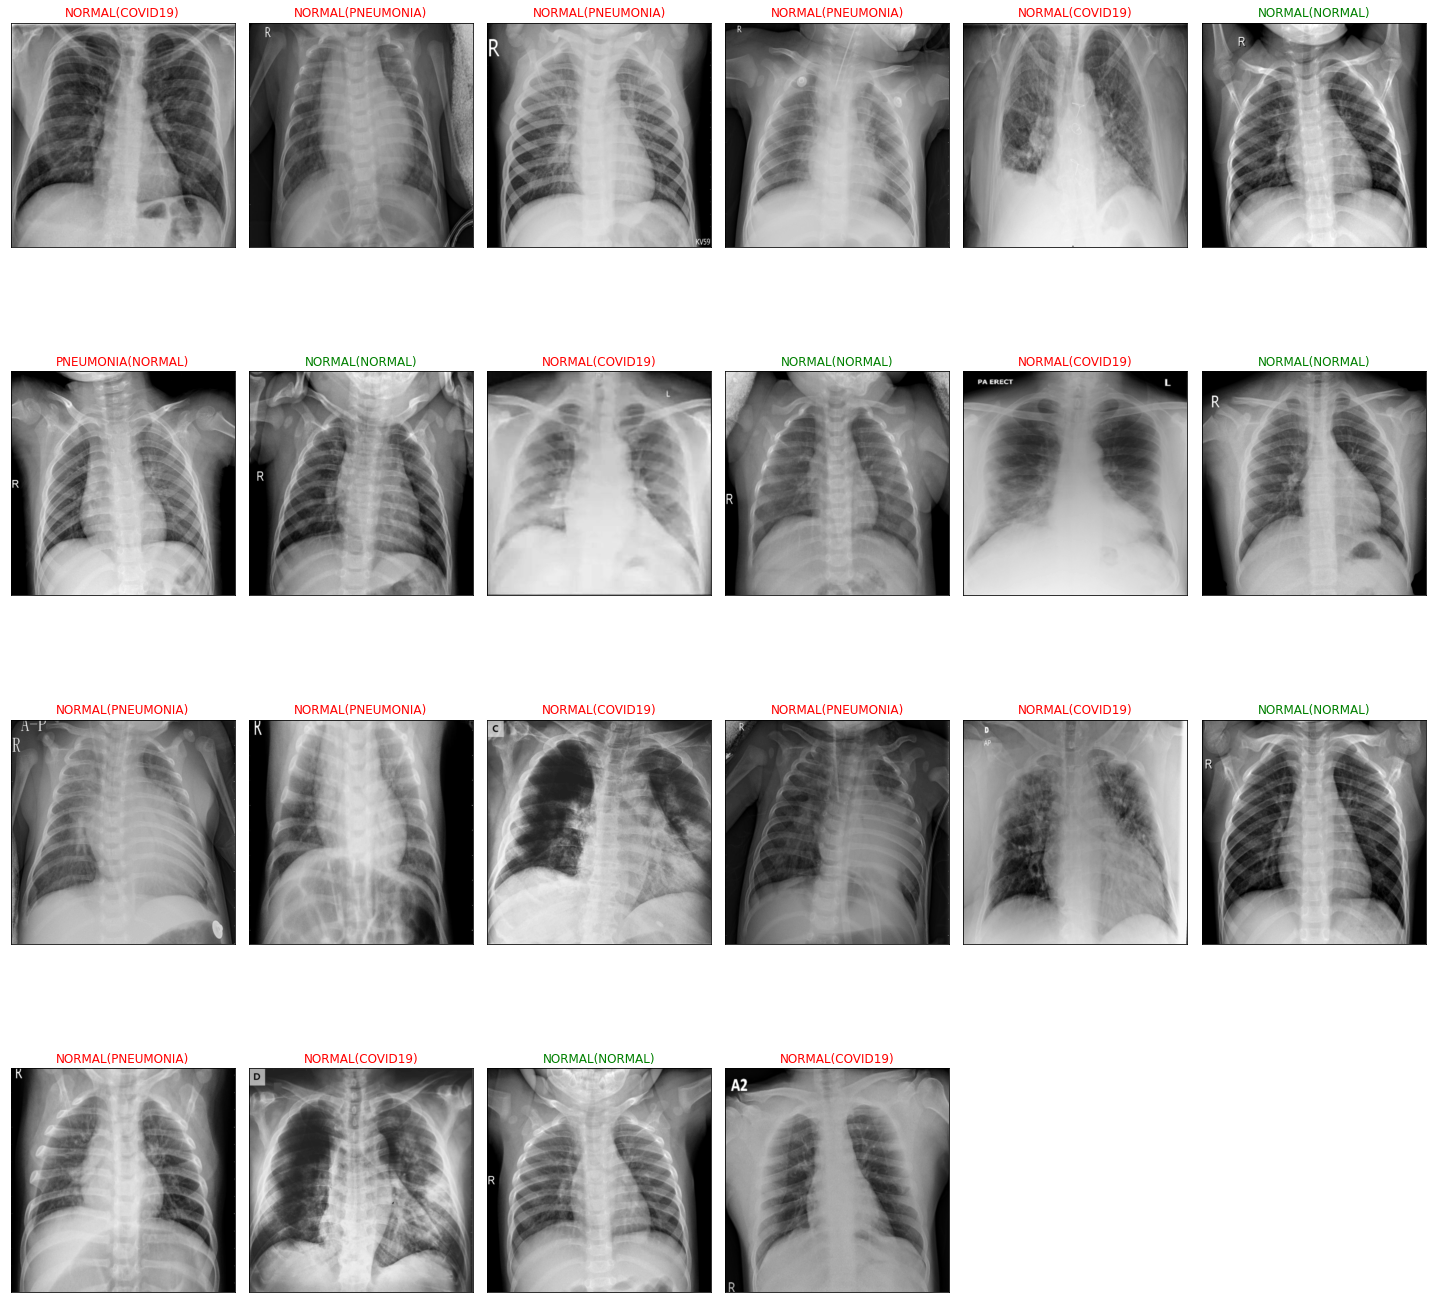

In [36]:
y_true, y_predict = predict_dataset(test_set, vgg16_model)
report(y_true, y_predict, 'VGG16')
plot_predict(test_set, y_predict)